# Persistencia homológica

Se va a visualizar la persitencia homológica de nubes de puntos que representan dígitos del 0 al 9. Para la visualización de la persistencia se hace el código de barras y el diagrama de persistencia

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import gudhi
gudhi.persistence_graphical_tools._gudhi_matplotlib_use_tex=False

C:\Users\diego\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Obtener los datos

Por cada dígito, se busca obtener una nube de puntos que represente al número

In [2]:
# resolucion de las imagendes de los digitos
resolucion = (40, 40)

# vairanza del ruido puesto en la nube
varianza_ruido = 0.3

In [3]:
# dada la matirz de una imagen
# hacer una nube de puntos
# tal que al dibujarla se dibuje la imagen
def obtener_nube_de_imagen(matriz):
    
    coordenadas = []
    
    # la matriz es nxm
    n = matriz.shape[0]
    m = matriz.shape[1]

    for i in range(n):
        for j in range(m):
            if matriz[i][j] >= 0.6:
                coordenadas.append((j, matriz.shape[1]-i))

    return np.array(coordenadas)

In [4]:
def poner_ruido_a_nube(nube):
    
    # definir el ruido
    # de la misma forma de la nube
    # cada elemento de la misma distribucio normal
    # con media 0 y varianza constante
    ruido = np.random.normal(loc=0, scale=varianza_ruido, size=(nube.shape[0], nube.shape[1]))
    
    return nube + ruido

In [5]:
def dibujar_nube(nube_puntos, ax):
        
    ax.scatter(nube_puntos[:, 0], nube_puntos[:, 1], s=3)
    
    ax.set_xlim(0, resolucion[0])
    ax.set_ylim(0, resolucion[1])
    
    # Remove x and y ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [6]:
def dibujar_imagen(imagen, ax):
        
    ax.imshow(imagen)
    
    # Remove x and y ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [7]:
# Cargar el conjunto de datos MNIST
(images, labels), (_, _) = mnist.load_data()

# definir los digitos del 0 al 9
digitos = np.array(list(range(0, 10)))

In [8]:
# Crear un diccionario
# pares de
# digito: una_imagen_de_ese_digito
dict_imagenes = {}

# iterar sobre los digitos
for digit in digitos:
    
    # tomar los indices de ese digito en mnist
    digit_indices = np.where(labels == digit)[0]
    
    # tomar las imagnenes de ese digito
    imagenes_digito = images[digit_indices]
        
    # tomar una imagen
    imagen_digito = images[digit_indices][0]
    
    # cambiar la resolucion
    imagen_digito_resolucion = resize(imagen_digito, resolucion)
    
    # ponerla en el diccionario
    dict_imagenes[digit] = imagen_digito_resolucion

In [9]:
# Crear un diccionario
# pares de
# digito: nube_de_puntos

dict_nubes = {}

# iterar sobre los digitos
for digit in digitos:
    
    # tomar la imagen del digito
    imagen_digito = dict_imagenes[digit]
    
    # obtener la nube de esa imagen
    nube_puntos = obtener_nube_de_imagen(imagen_digito)
    
    # ponerla en el diccionario
    dict_nubes[digit] = nube_puntos

In [10]:
# Crear un diccionario
# pares de
# digito: nube_de_puntos_con_ruido

dict_nubes_ruido = {}

# iterar sobre los digitos
for digit in digitos:
    
    # poner la nube con ruido
    dict_nubes_ruido[digit] = poner_ruido_a_nube(dict_nubes[digit])

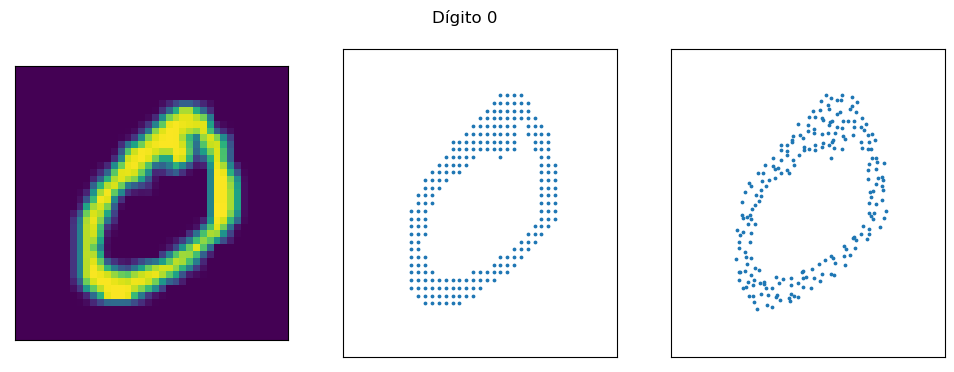

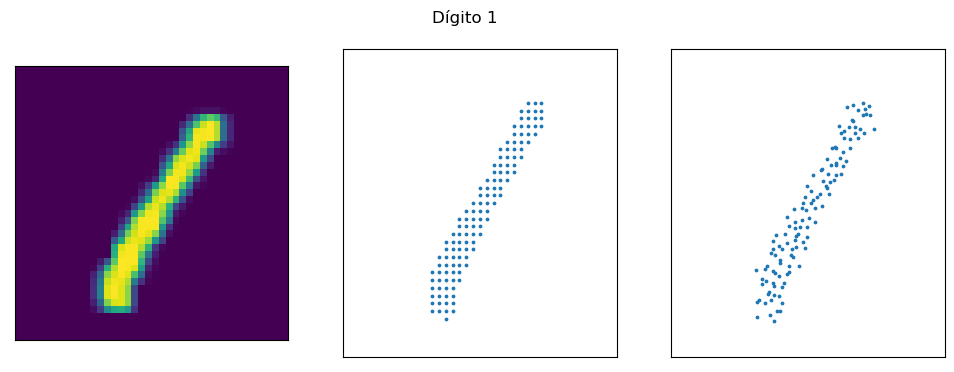

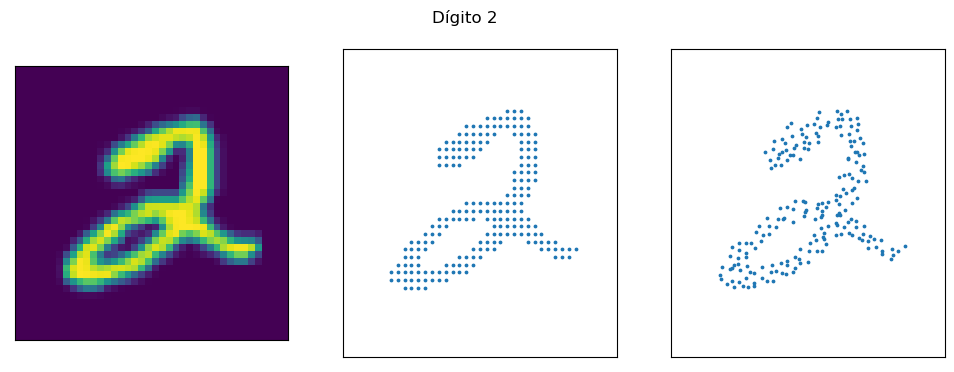

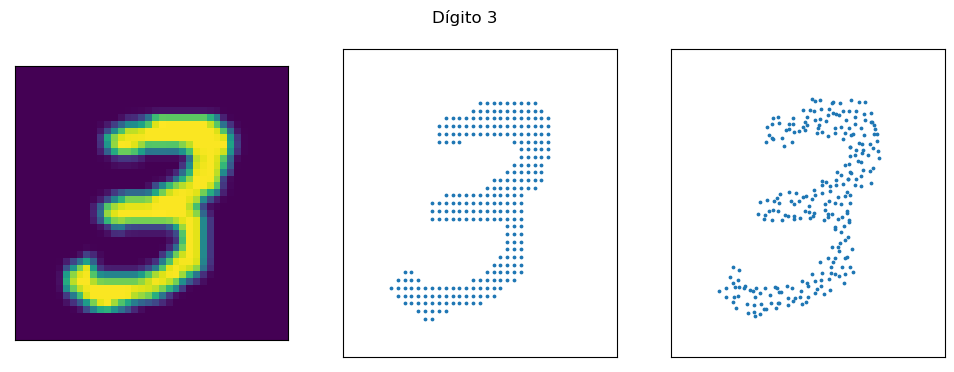

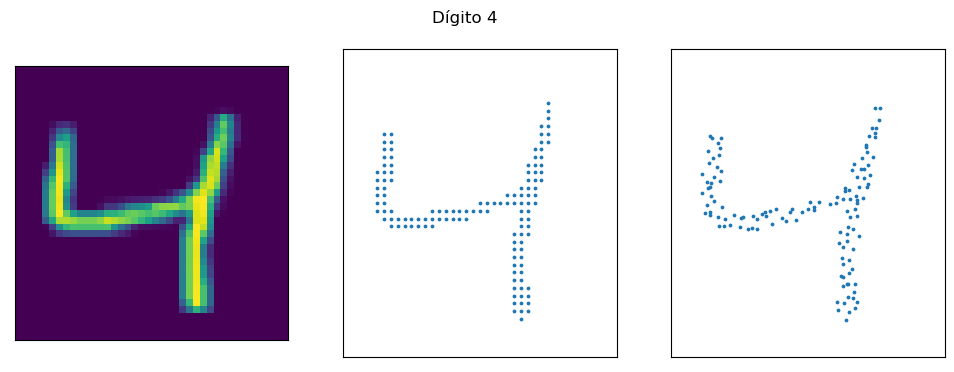

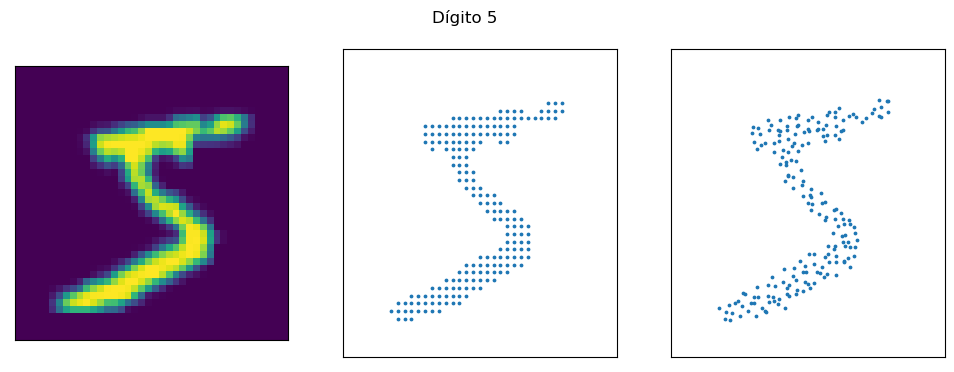

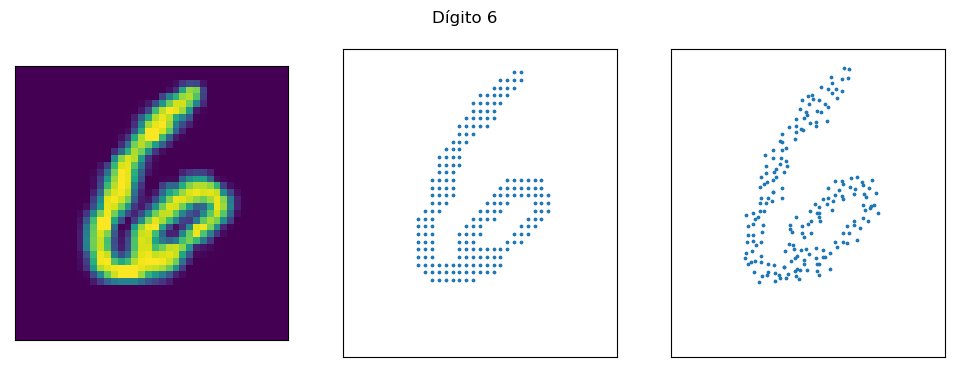

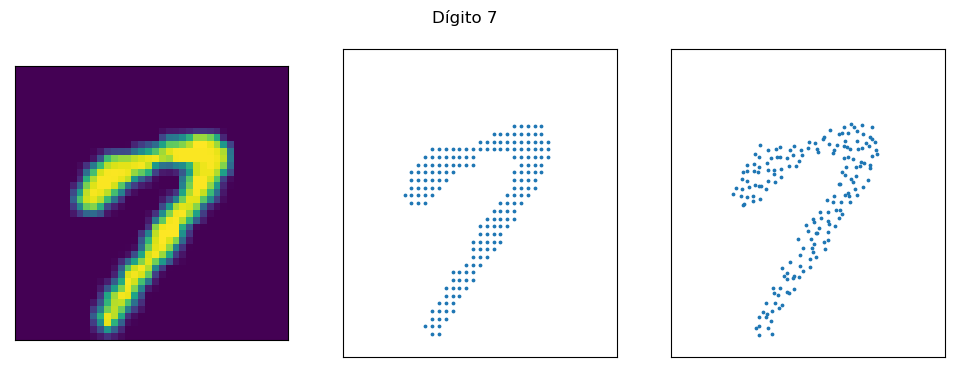

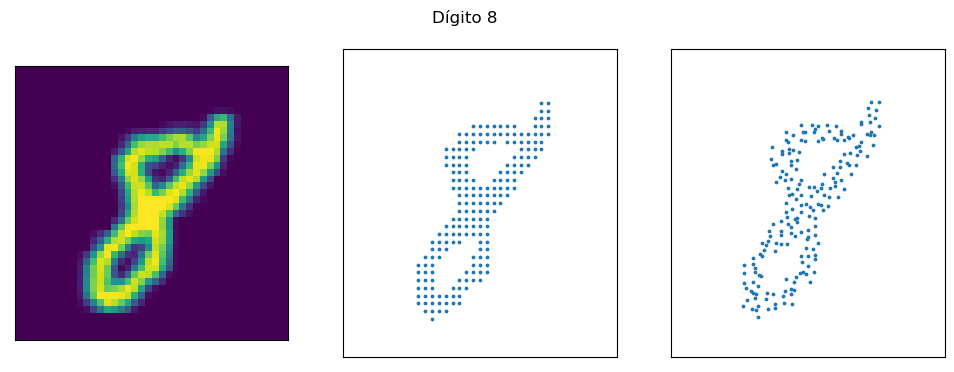

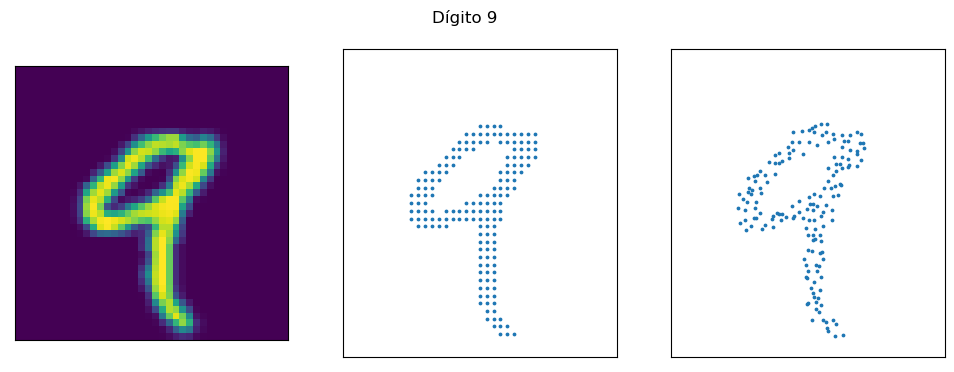

In [11]:
# por cada digito
for digit in digitos:
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    
    # ver la imagen tomada
    dibujar_imagen(dict_imagenes[digit], ax[0])
    
    # ver la nube
    dibujar_nube(dict_nubes[digit], ax[1])
    
    # ver la nube con ruido
    dibujar_nube(dict_nubes_ruido[digit], ax[2])
    
    fig.suptitle(f"Dígito {digit}")    
    # ver la imagen
    plt.show()
    

In [12]:
# por cada digito
for digit in digitos:
    # ver cuantos datos tiene
    print(f"Para el dígito {digit} se tienen {len(dict_nubes[digit])} datos en la nube")

Para el dígito 0 se tienen 220 datos en la nube
Para el dígito 1 se tienen 121 datos en la nube
Para el dígito 2 se tienen 207 datos en la nube
Para el dígito 3 se tienen 262 datos en la nube
Para el dígito 4 se tienen 127 datos en la nube
Para el dígito 5 se tienen 193 datos en la nube
Para el dígito 6 se tienen 198 datos en la nube
Para el dígito 7 se tienen 179 datos en la nube
Para el dígito 8 se tienen 198 datos en la nube
Para el dígito 9 se tienen 165 datos en la nube


## Analizar la Persistencia Homológica

Por cada nube de puntos:

1) Filtración simplicial de Vietoris-Rips

2) Diagrama de persistencia de la filtración

3) Código de barras de la filtración

RipsComplex:
https://gudhi.inria.fr/python/latest/rips_complex_ref.html

Simplex tree (filtracion): https://gudhi.inria.fr/python/latest/simplex_tree_ref.html

Diagramas: https://gudhi.inria.fr/python/latest/persistence_graphical_tools_user.html#

https://gudhi.inria.fr/python/latest/persistence_graphical_tools_ref.html


In [25]:
# funcion para calcular la homologia persistente de un digito
def homologia_digito(digito):
    
    # tomar la nube de puntos con ruido
    puntos_digito = dict_nubes_ruido[digito]
    
    # convertir al formato requerrido (lista de lista)
    puntos = [list(point) for point in puntos_digito]
    
    # definir el comlpejo de Vietoris–Rips con los puntos
    rips = gudhi.RipsComplex(points = puntos)
    
    # hacer la filtracion de Vietoris–Rips
    filtracion = rips.create_simplex_tree(max_dimension=2)
    
    # ya que se tiene la filtracion
    # calcular la persistencia
    persistencia = filtracion.persistence()
    
    # graficar el codigo de barras y diagrama de persistenica
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))

    # ver el codigo de barras
    gudhi.plot_persistence_barcode(persistencia, axes = ax[0])

    # ver el diagrama de persitencia
    gudhi.plot_persistence_diagram(persistencia, axes = ax[1])

    # ver la imagen
    fig.suptitle(f"Dígito {digito}", fontsize = 20)    
    plt.show()
    
    # ver la nube de puntos
    fig, ax = plt.subplots(figsize = (5, 5))
    
    dibujar_nube(puntos_digito, ax)
    ax.set_title("Nube de puntos del dígito")
    
    plt.show()

## Comenzar el análisis individual de cada dígito

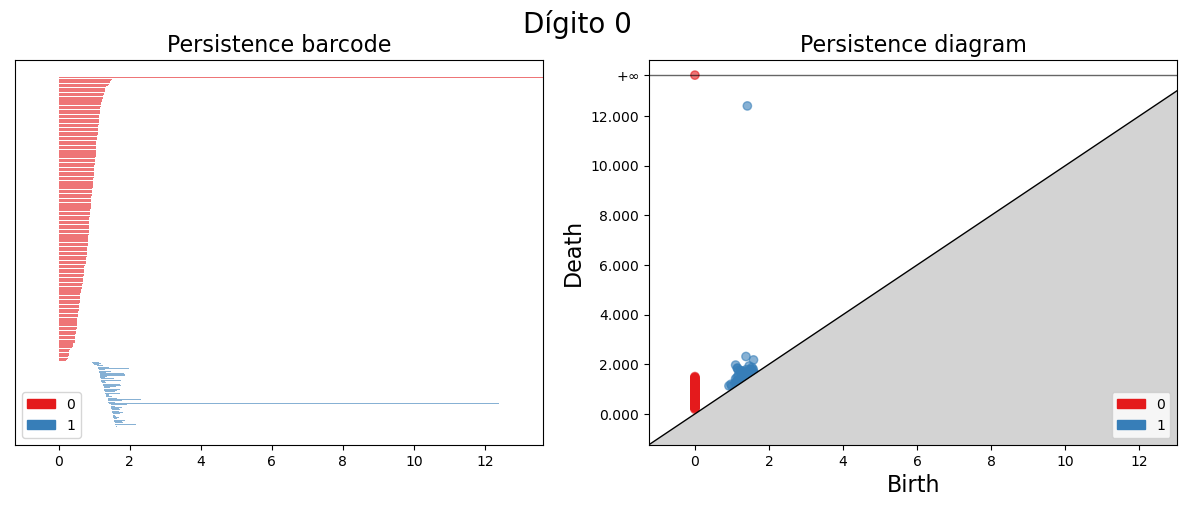

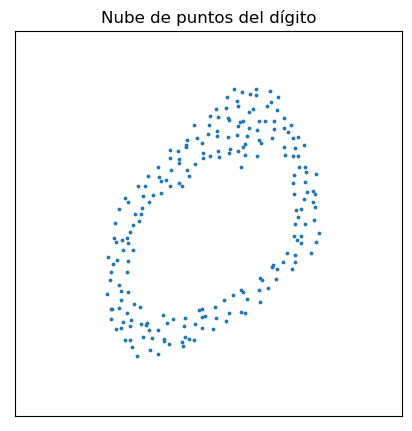

In [14]:
homologia_digito(0)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y también tiene un hueco (un 1-hoyo).

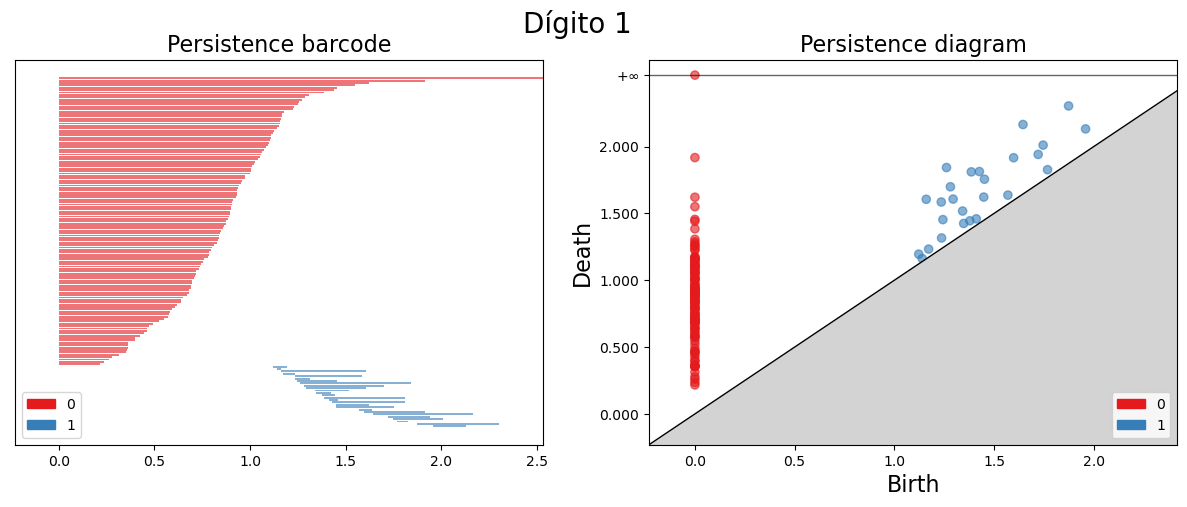

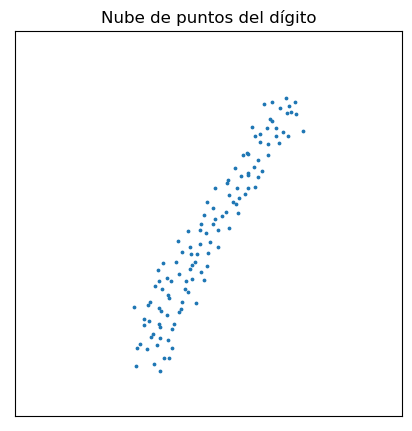

In [15]:
homologia_digito(1)

Se puede ver que se tiene un componente conexo (un 0-hoyo). Dado que este número no tiene ningún hoyo relevante (de gran tamaño), la escala de los diagramas se modifica, es muy corta, pues con poco radio de la filtración se obtienen todos los simplejos de dimensión 1. Debido a esto, se puede ver mucho ruido, hay muchos hoyos que parecerían ser un poco significativos (estan despegados de la diagonal), pero esto es ruido.

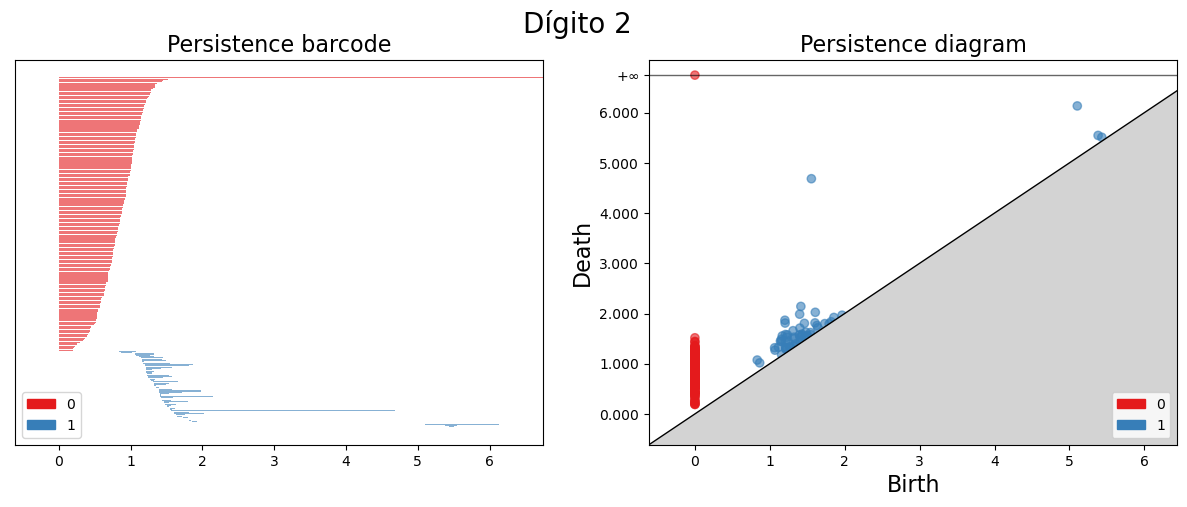

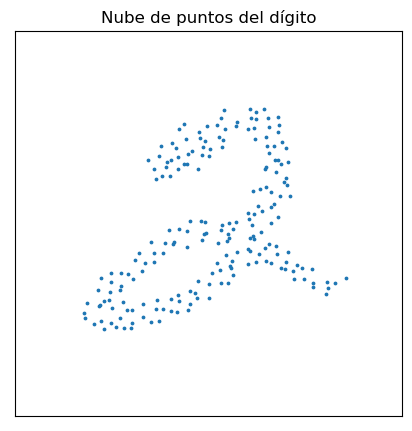

In [16]:
homologia_digito(2)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y también tiene un hueco (un 1-hoyo) de tamaño mediano.

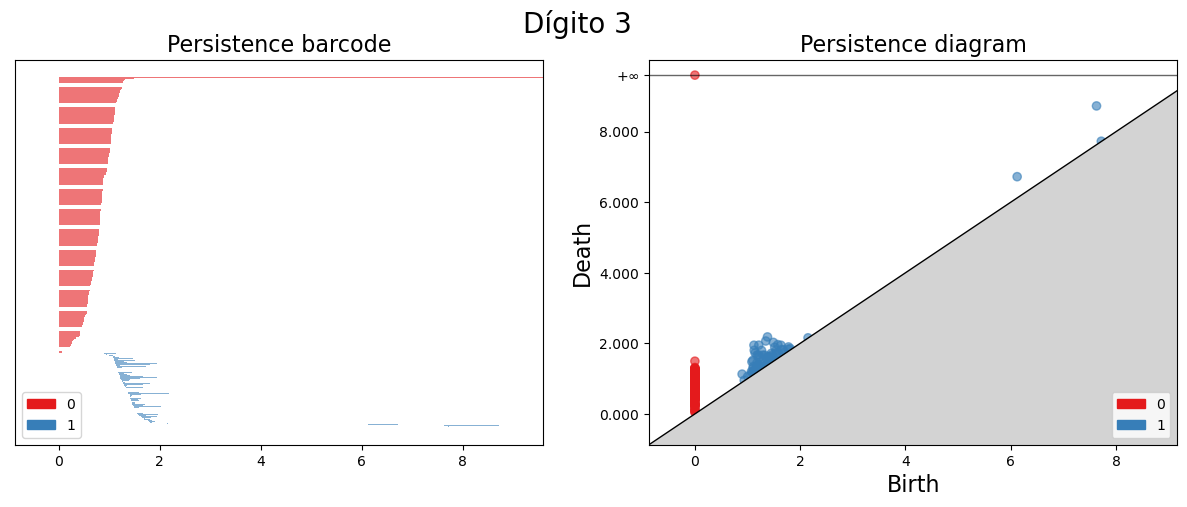

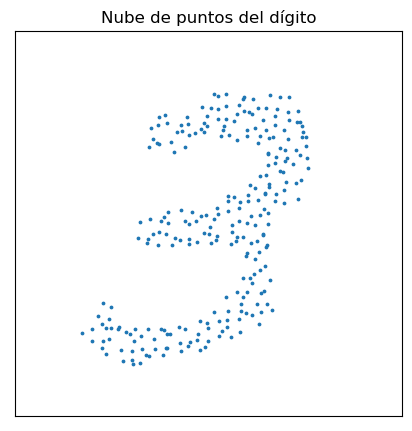

In [17]:
homologia_digito(3)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y ya, lo demás es ruido.

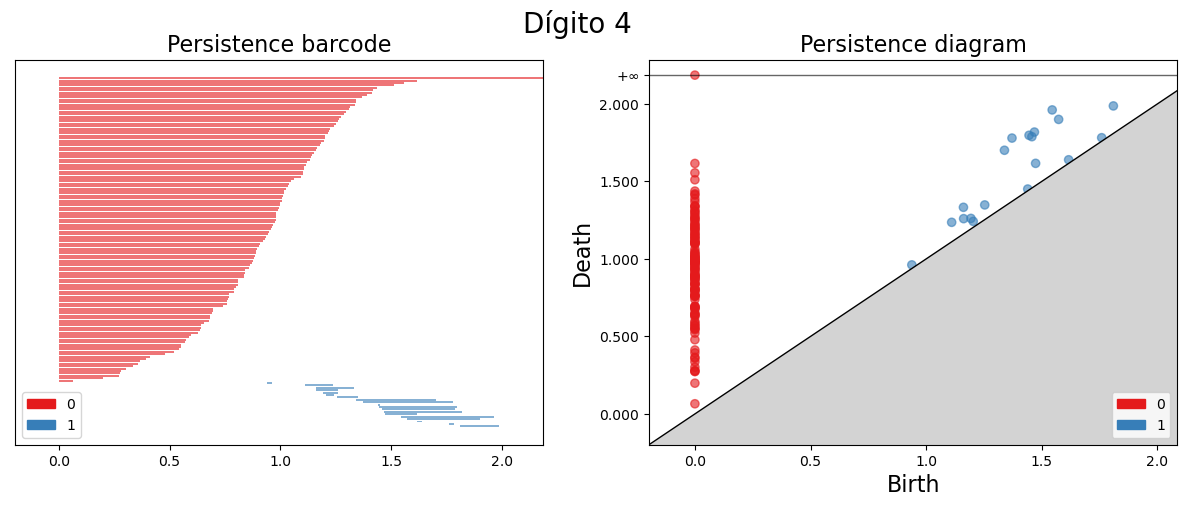

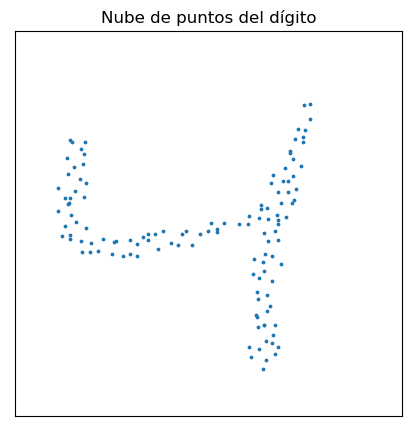

In [18]:
homologia_digito(4)

Al igual que con el dígito 1, se tiene mucho ruido, parecería que hay algunos hoyos. Sin embargo, solo se tiene un 0-hoyo.

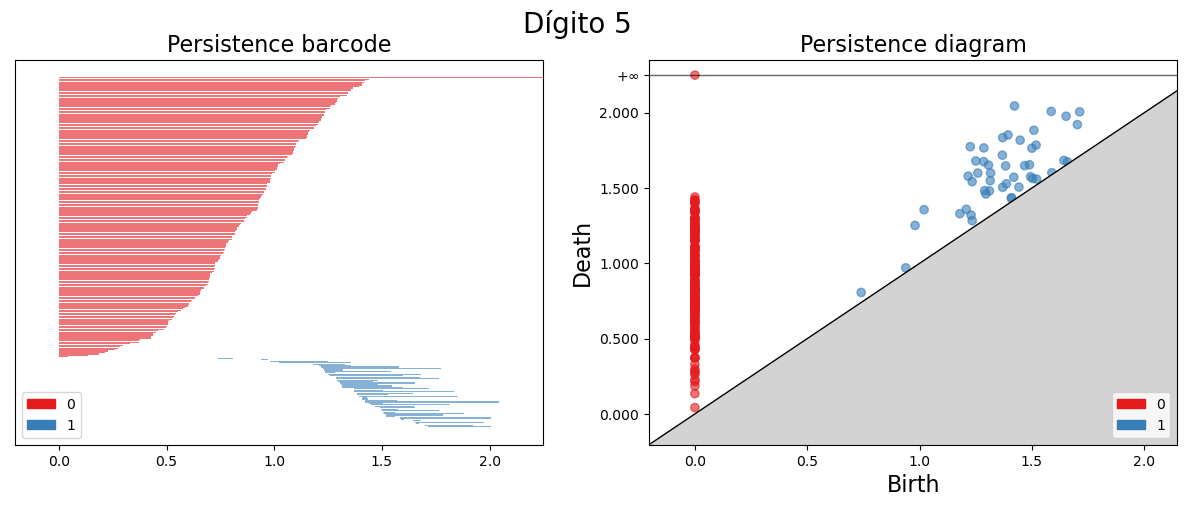

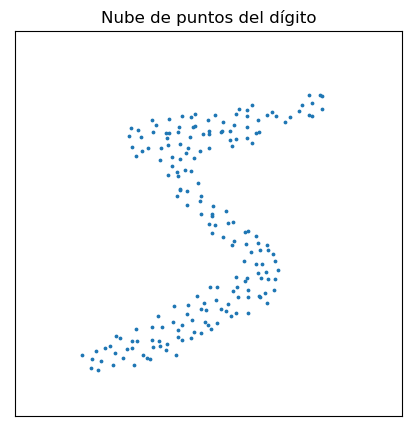

In [19]:
homologia_digito(5)

Al igual que con los dígitos 1 y 4, solo se tiene un 0-hoyo y mucho ruido.

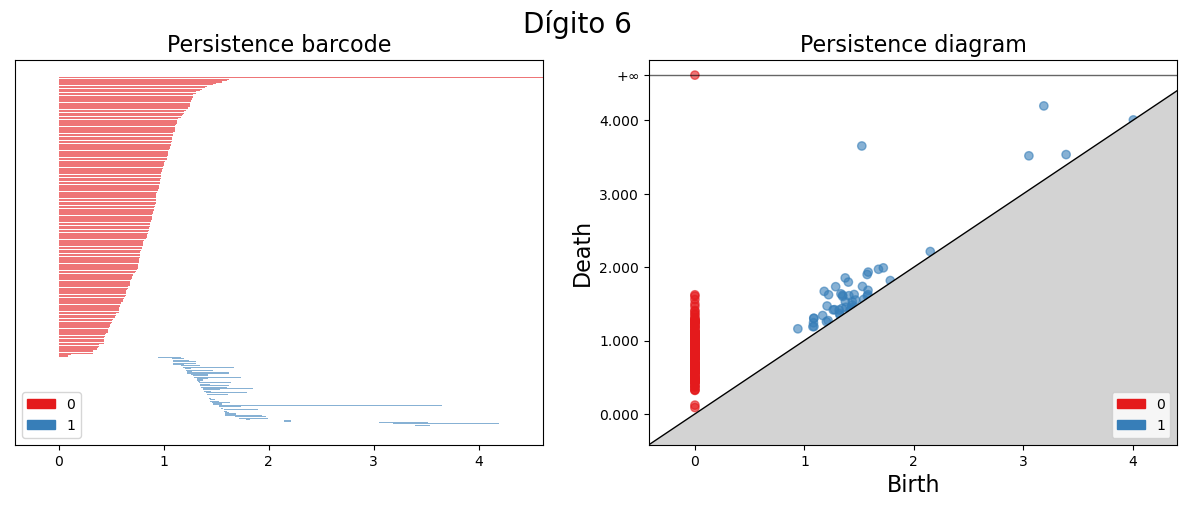

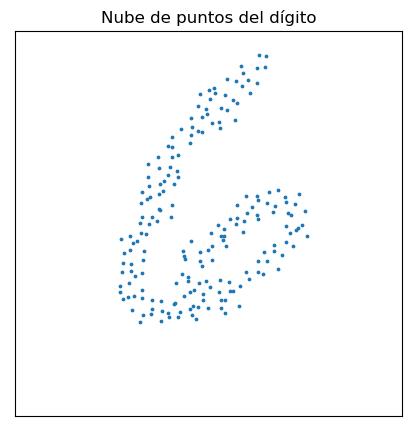

In [20]:
homologia_digito(6)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y también tiene un hueco (un 1-hoyo). También hay otro 1-hoyo que podria considerarse que no sea ruido, este se puede ver en la nube de puntos, es una irregularidad en el digito.

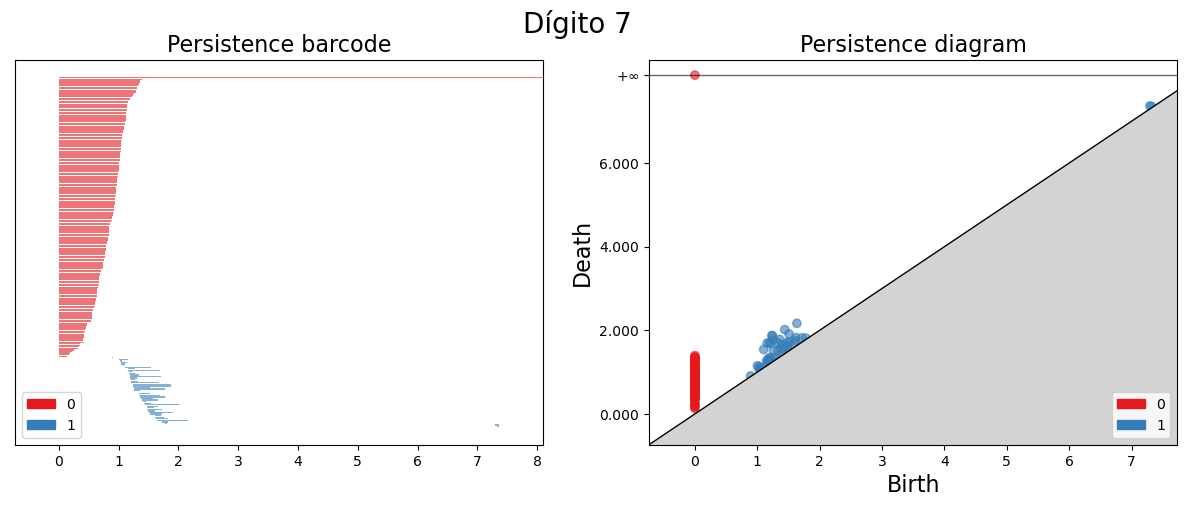

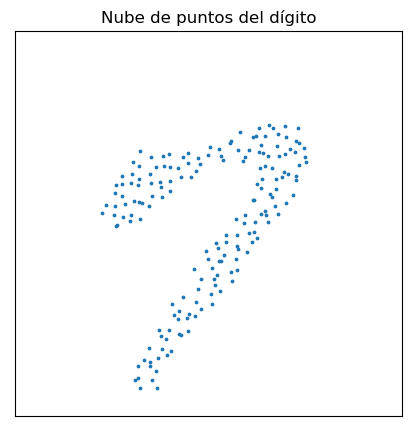

In [21]:
homologia_digito(7)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y ya.

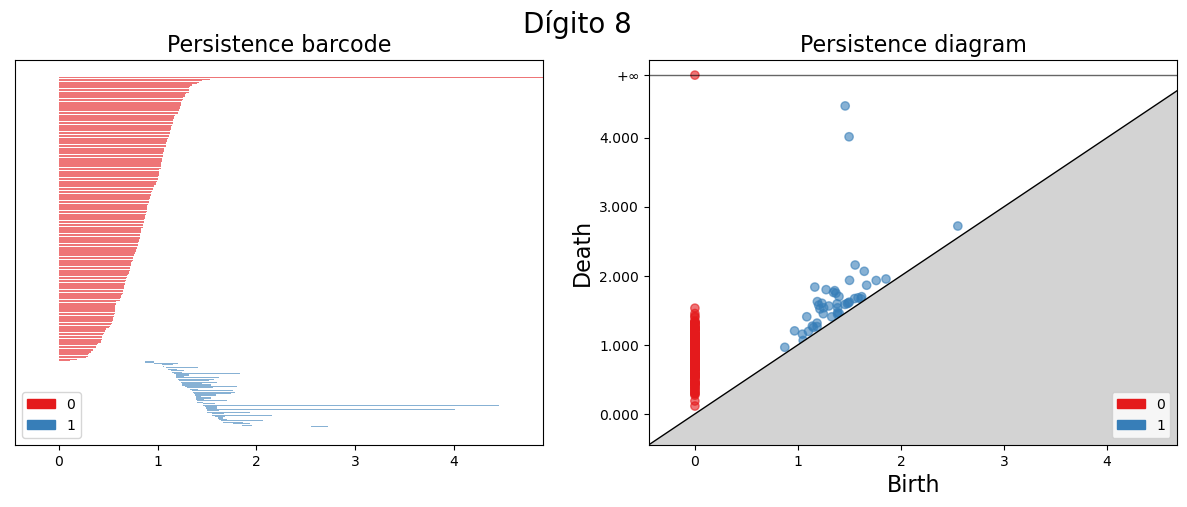

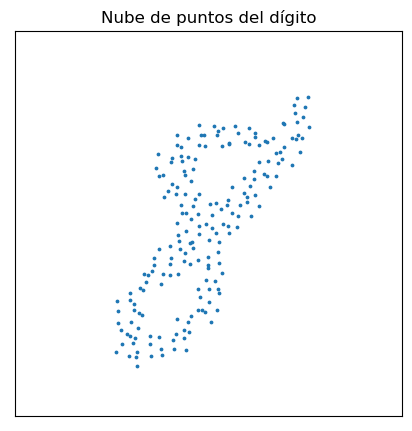

In [22]:
homologia_digito(8)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y también tiene dos huecos (dos 1-hoyos)

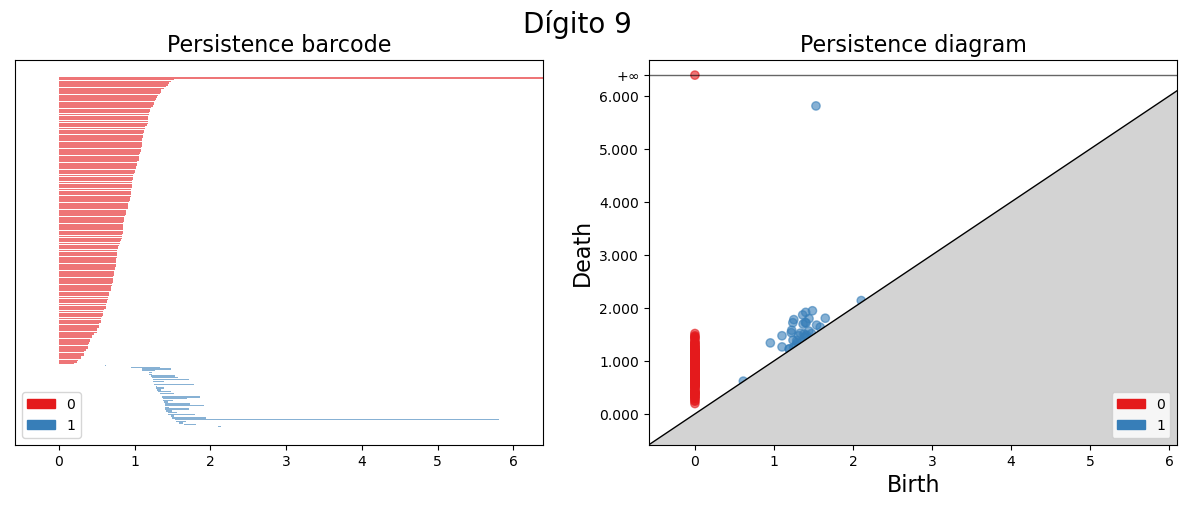

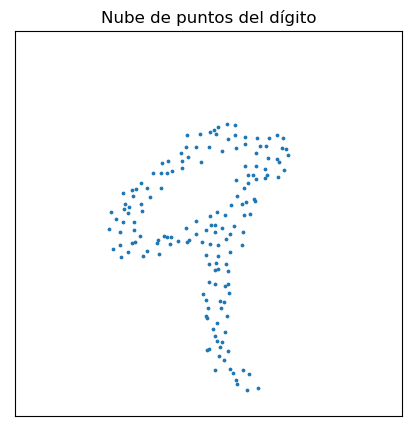

In [23]:
homologia_digito(9)

Es claro que este dígito tiene un componente conexo (un 0-hoyo) y también tiene un hueco (un 1-hoyo)